In [1]:
#Librerias básicas
#================================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import duckdb
import glob

# Configuración para machine learning
# ================================================================================
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from pandas.core.frame import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import multiprocessing

import cv2

# Activar SQL en Python
# ================================================================================
con = duckdb.connect(database=':memory:')

In [2]:
#Urls Pater
url_lcc = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet-detection-with-Neural-Network/Curvas_de_luz_cor/"
url    = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet-detection-with-Neural-Network/"

In [3]:
#Url Ari
url_lcc = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet-detection-with-Neural-Network/Curvas_de_luz_cor/"
url    = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet-detection-with-Neural-Network/"

In [4]:
Carac_Stars = pd.read_csv(url+"Carac_Stars.csv")
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [5]:
arch = os.listdir(url_lcc) 
arch.sort()
Stars_list = [star[3:-4] for star in arch]

s_flux  = []
s_err   = []
Id_real = []
for Str in arch:
    serie = pd.read_csv(url_lcc+Str).set_index('time')
    if len(serie) == 1285:
        s_flux.append(np.array(serie['flux']))
        s_err.append(np.array(serie['flux_err']))
        Id_real.append(Str[3:-4])
    else:
        continue


In [6]:
Stars = pd.DataFrame()
Stars["ID"] = Id_real
Stars

,ID
0,10000162
1,10000941
2,10001368
3,10002049
4,10002266
...,...
7201,9993683
7202,9994381
7203,9995402
7204,9995771


In [7]:
Clas_Stars = con.execute("""select S.ID, case when C.Clasificacion == 'CANDIDATE' then 1 
                                              else 0             
                                         end as ClasBin
                            from Carac_Stars C inner join Stars S on (S.ID = C.Kepler_ID)
                            order by S.ID""").df()
Clas_Stars

,ID,ClasBin
0,10000162,1
1,10000941,1
2,10001368,1
3,10002049,1
4,10002266,0
...,...,...
7201,9993683,1
7202,9994381,1
7203,9995402,1
7204,9995771,1


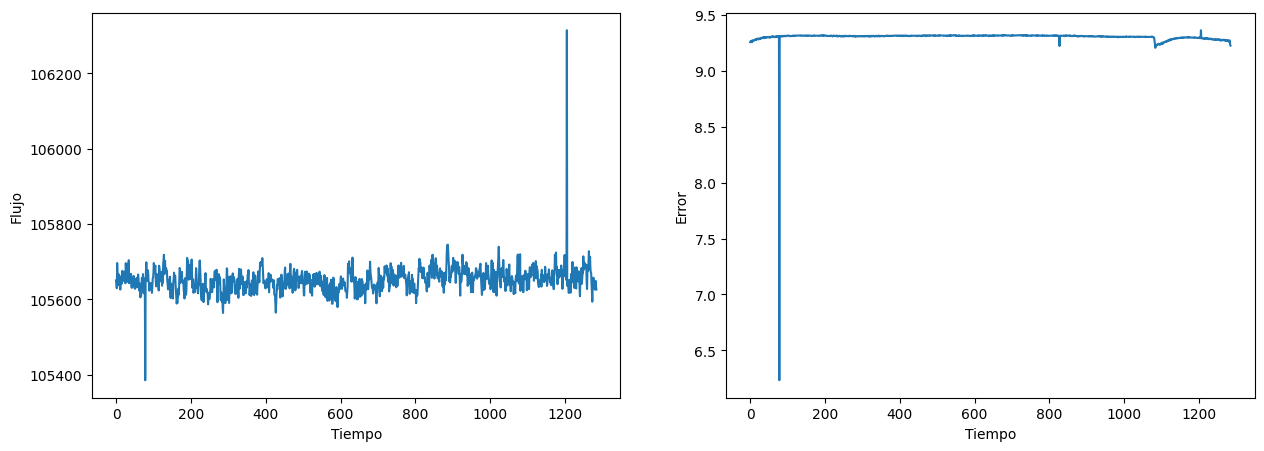

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_flux[198])
#plt.title(f'Curva de luz de la estrella {Stars[190]}') 
plt.ylabel('Flujo')
plt.xlabel('Tiempo')

plt.subplot(1,2,2)

plt.plot(s_err[198])
#plt.title(f'Error de la curva de luz de la estrella {Stars[190]}') 
plt.ylabel('Error')
plt.xlabel('Tiempo')

plt.show()

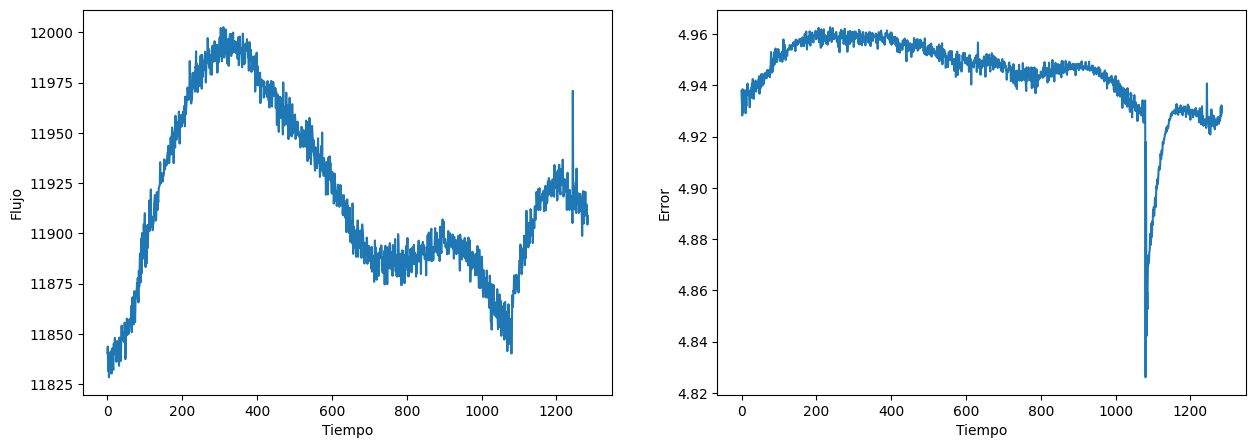

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_flux[6480])
#plt.title(f'Curva de luz de la estrella {Stars[6481]}') 
plt.ylabel('Flujo')
plt.xlabel('Tiempo')

plt.subplot(1,2,2)

plt.plot(s_err[6480])
#plt.title(f'Error de la curva de luz de la estrella {Stars[6481]}') 
plt.ylabel('Error')
plt.xlabel('Tiempo')

plt.show()

## Red Convolucional (CNN)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(np.array(s_flux), 
                                                    np.array(Clas_Stars["ClasBin"]),
                                                    test_size=0.3)

X_val,  X_test,  y_val,  y_test  = train_test_split(X_test, 
                                                    y_test,
                                                    test_size=0.333)
for i in range(len(X_train)):
    mean_i = np.mean(X_train[i])
    std_i  = np.std(X_train[i])
    X_train[i] = (X_train[i] - mean_i)/std_i
    
for i in range(len(X_val)):
    mean_i = np.mean(X_val[i])
    std_i  = np.std(X_val[i])
    X_val[i] = (X_val[i] - mean_i)/std_i

X_train = X_train.reshape((len(X_train), 1285, 1))
X_test  = X_test.reshape((len(X_test), 1285, 1))
X_val   = X_val.reshape((len(X_val), 1285, 1))

print("Tamaño de entrenamiento:",X_train.shape,
      "\nTamaño de validacion:",X_val.shape,
      "\nTamaño de prueba:", X_test.shape,
      "\nDatos totales:",len(X_train)+len(X_val)+len(X_test))

Tamaño de entrenamiento: (5044, 1285, 1) 
Tamaño de validacion: (1442, 1285, 1) 
Tamaño de prueba: (720, 1285, 1) 
Datos totales: 7206


In [11]:
len(y_train[y_train==1])

2130

In [12]:
len(y_train[y_train==0])

2914

In [51]:
model = tf.keras.models.Sequential([
    #tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(1285,1)),
    #tf.keras.layers.AveragePooling1D(pool_size=2),
    #tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
    #tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Flatten(input_shape=(1285,1)),
    tf.keras.layers.Dense(1500, activation='tanh'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

In [42]:
#CallBack para detener entrenamiento
class MNIST_Callback(tf.keras.callbacks.Callback):
    
    # método dentro de la clase myCallback, heredada de la clase Callback de keras
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.985):
            print("\nSe alcanzó un 98.5% de precisión en la validación! Cancelando Entrenamiento...")
            self.model.stop_training = True
        elif(logs.get('accuracy')>0.9):
            print("\nSe alcanzó un 90.0% de precisión en el entrenaminto! Cancelando Entrenamiento...")
            self.model.stop_training = True


# crea una instancia de clase
accu_callback = MNIST_Callback()

In [52]:
#Compilador del modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 1285)              0         
                                                                 
 dense_37 (Dense)            (None, 1500)              1929000   
                                                                 
 dense_38 (Dense)            (None, 1000)              1501000   
                                                                 
 dense_39 (Dense)            (None, 500)               500500    
                                                                 
 dense_40 (Dense)            (None, 1)                 501       
                                                                 
Total params: 3931001 (15.00 MB)
Trainable params: 3931001 (15.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    validation_data = (X_val,y_val),
                    batch_size=16,
                    callbacks=[accu_callback])

Epoch 1/20
316/316 [==============================] - 17s 50ms/step - loss: nan - accuracy: 0.5751 - val_loss: nan - val_accuracy: 0.5700
Epoch 2/20
316/316 [==============================] - 13s 42ms/step - loss: nan - accuracy: 0.5753 - val_loss: nan - val_accuracy: 0.5700
Epoch 3/20
316/316 [==============================] - 14s 45ms/step - loss: nan - accuracy: 0.5753 - val_loss: nan - val_accuracy: 0.5700
Epoch 4/20
316/316 [==============================] - 13s 41ms/step - loss: nan - accuracy: 0.5753 - val_loss: nan - val_accuracy: 0.5700
Epoch 5/20
316/316 [==============================] - 14s 44ms/step - loss: nan - accuracy: 0.5753 - val_loss: nan - val_accuracy: 0.5700
Epoch 6/20
316/316 [==============================] - 13s 41ms/step - loss: nan - accuracy: 0.5753 - val_loss: nan - val_accuracy: 0.5700
Epoch 7/20
316/316 [==============================] - 13s 40ms/step - loss: nan - accuracy: 0.5753 - val_loss: nan - val_accuracy: 0.5700
Epoch 8/20
316/316 [==============

KeyboardInterrupt: 